# Abreu-Sannikov Algorithm for Repeated Two-player Games

*Zejin Shi*

This notebook demonstrates the usage of Python implementation of Abreu-Sannikov algorithm (hereafter AS algorithm) for computing the set of payoff pairs of all pure-strategy subgame-perfect equilibria with public randomization for any repeated two-player games with perfect monitoring and discounting, which is proposed by Abreu and Sannikov (2014).

The idea of how to compute the equilibrium payoff set of a repeated two-player game is first proposed by Abreu et al. (1990) (hereafter APS). They suggest to apply a set operator $B$ to the initial guess of equilibrium payoff set $W_0$ iteratively, until it reaches a fxied point $B(W_N)=W_N = V^*$. The convergence is guaranteed, as proven in the paper.

Judd et al. (2003) (usually referred to as JYC) solves linear programming problems to implement the procedure of applying $B$ to $W_N$ iteratively. They approximate set $W_N$ by supporting hyperplanes, and each operation of $B$ is to iterate the action profiles and update supporting hyperplanes of the new set $W_{N+1}$.

AS algorithm has computational gains relative to APS algorithm (and its numerical implementation JYC algorithm) by understanding how the extreme points of the equilibrium payoff set are generated. They find that each action profile can at most generates 4 extreme points of $V^*$. This makes sure the complexity of approximating and operating of $W_N$ at each round will not increase exponentially.

In the following, I will demonstrate how to apply the Python implementation of AS algorithm to three examples. The speed of the algorithm is quite fast.

In [1]:
from quantecon import game_theory as gt
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

# Abreu and Sannikov (2014) Example

We start with the example used in Abreu and Sannikov (2014).

In [3]:
p1 = gt.Player([[16, 3, 0], [21, 10, -1], [9, 5, -5]])
p2 = gt.Player([[9, 1, 0], [13, 4, -4], [3, 0, -15]])

# the stage game
sg = gt.NormalFormGame([p1, p2])

# discount rate
δ = 0.3

# create a repeated two-player game
rpg = gt.RepeatedGame(sg, δ)

AS algorithm is implemented as a method of `RepeatedGame` class. It can be called by `RepeatedGame.equilibrium_payoffs(method='AS', options={"u_init": u_init})` where `u_init` should be the initial guess of the threat points. It will return a `scipy.spatial.ConvexHull` instance which is $V^*$.

In [4]:
# compute the equilibrium payoff set V*
hull = rpg.equilibrium_payoffs(method='AS', options={"u_init": np.zeros(2)})

# get the initial guess of payoff set W0
# which can be simply the convex hull of action profile payoffs
hull0 = ConvexHull(sg.payoff_profile_array.reshape(np.prod(sg.nums_actions), 2))

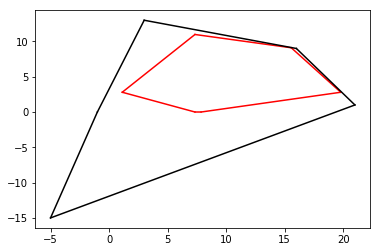

In [5]:
# plot V*
for simplex in hull.simplices:
    plt.plot(hull.points[simplex, 0], hull.points[simplex, 1], 'r-')

# plot W0
for simplex in hull0.simplices:
    plt.plot(hull0.points[simplex, 0], hull0.points[simplex, 1], 'k-')

Because the default `method` and `u_init` option of `RepeatedGame.equilibrium_payoffs()` are set to be `'AS'` and `np.zeros(2)`, we can skip passing their values in this example.

The speed of AS algorithm is showed below.

In [6]:
%timeit rpg.equilibrium_payoffs()
%timeit rpg.equilibrium_payoffs()
%timeit rpg.equilibrium_payoffs()

20.4 ms ± 2.81 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
26.7 ms ± 1.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
25.6 ms ± 4.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Prisoner's Dilemma

Here we apply AS algorithm to the classical Prisoner's dilemma example.

In [7]:
pd_payoff = [[9.0, 1.0],
             [10.0, 3.0]]
p1 = gt.Player(pd_payoff)
p2 = gt.Player(pd_payoff)

sg = gt.NormalFormGame((p1, p2))
δ = 0.9

rpg = gt.RepeatedGame(sg, δ)

In [8]:
# we set the initial guess of threat points as [3, 3], which is the minimax payoffs
hull = rpg.equilibrium_payoffs(options={'u_init': np.array([3., 3.])})
hull0 = ConvexHull(sg.payoff_profile_array.reshape(np.prod(sg.nums_actions), 2))

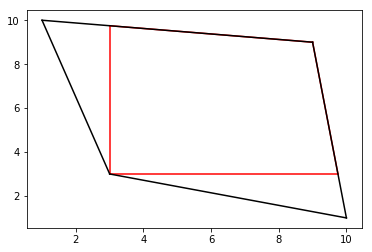

In [9]:
# V*
for simplex in hull.simplices:
    plt.plot(hull.points[simplex, 0], hull.points[simplex, 1], 'r-')
    
# W0
for simplex in hull0.simplices:
    plt.plot(hull0.points[simplex, 0], hull0.points[simplex, 1], 'k-')

In [10]:
%timeit rpg.equilibrium_payoffs(options={'u_init': np.array([3., 3.])})
%timeit rpg.equilibrium_payoffs(options={'u_init': np.array([3., 3.])})
%timeit rpg.equilibrium_payoffs(options={'u_init': np.array([3., 3.])})

2.22 ms ± 256 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.88 ms ± 184 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.74 ms ± 106 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Cournot Duopoly Game

Because the complexity of computation of AS algorithm is bounded, it can be used to deal with large scale games (in terms of the number of actions). Here we apply it to the Cournot Duopoly Game which is also used in JYC.

In [11]:
# copy and paste from 
# http://nbviewer.jupyter.org/github/QuantEcon/QuantEcon.notebooks/blob/master/game_theory_py.ipynb
from quantecon import cartesian


def cournot(a, c, N, q_grid):
    """
    Create a `NormalFormGame` instance for the symmetric N-player Cournot game
    with linear inverse demand a - Q and constant marginal cost c.

    Parameters
    ----------
    a : scalar
        Intercept of the demand curve

    c : scalar
        Common constant marginal cost

    N : scalar(int)
        Number of firms

    q_grid : array_like(scalar)
        Array containing the set of possible quantities

    Returns
    -------
    NormalFormGame
        NormalFormGame instance representing the Cournot game

    """
    q_grid = np.asarray(q_grid)
    payoff_array = \
        cartesian([q_grid]*N).sum(axis=-1).reshape([len(q_grid)]*N) * (-1) + \
        (a - c)
    payoff_array *= q_grid.reshape([len(q_grid)] + [1]*(N-1))
    payoff_array += 0  # To get rid of the minus sign of -0

    player = gt.Player(payoff_array)
    return gt.NormalFormGame([player for i in range(N)])

In [12]:
a, c = 6, 0.6
N = 2
q_grid = np.linspace(0, 6, 15)

sg = cournot(a, c, N, q_grid)
δ = 0.8

# create the repeated cournot game
rpg = gt.RepeatedGame(sg, δ)

In [13]:
hull = rpg.equilibrium_payoffs()
hull0 = ConvexHull(sg.payoff_profile_array.reshape(np.prod(sg.nums_actions), 2))

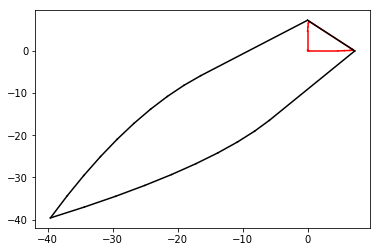

In [14]:
# V*
for simplex in hull.simplices:
    plt.plot(hull.points[simplex, 0], hull.points[simplex, 1], 'r-')
    
# W0
for simplex in hull0.simplices:
    plt.plot(hull0.points[simplex, 0], hull0.points[simplex, 1], 'k-')

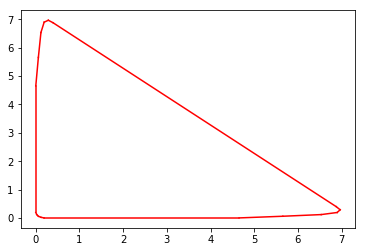

In [15]:
# focus on the shape of V*
for simplex in hull.simplices:
    plt.plot(hull.points[simplex, 0], hull.points[simplex, 1], 'r-')

In [16]:
%timeit rpg.equilibrium_payoffs()
%timeit rpg.equilibrium_payoffs()
%timeit rpg.equilibrium_payoffs()

57.9 ms ± 2.62 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
62.9 ms ± 2.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
67.2 ms ± 7.93 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# References

- Abreu, D., Pearce, D., & Stacchetti, E. (1990). Toward a theory of discounted repeated games with imperfect monitoring. Econometrica: Journal of the Econometric Society, 1041-1063.
- Judd, K. L., Yeltekin, S., & Conklin, J. (2003). Computing supergame equilibria. Econometrica, 71(4), 1239-1254.
- Abreu, D., & Sannikov, Y. (2014). An algorithm for two‐player repeated games with perfect monitoring. Theoretical Economics, 9(2), 313-338.